<a href="https://colab.research.google.com/github/MedBALBSIR/PC-labs-MLF-BALBSIR-Mohammed/blob/main/Ex_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPA-MLF, Lab 6 - Feedforward Neural Networks with regularization techniques and hyperparameter tunning

## Exercise 1 - Classification of an images

The goal of this task will be to create Multi-layer perceptron model, that is able to recognize the  CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR10 dataset consist of 60000 images with resolution of 32x32 pixels. There are 10 classes in total - *airplane*, *automobile*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*

These is an example of the dataset:

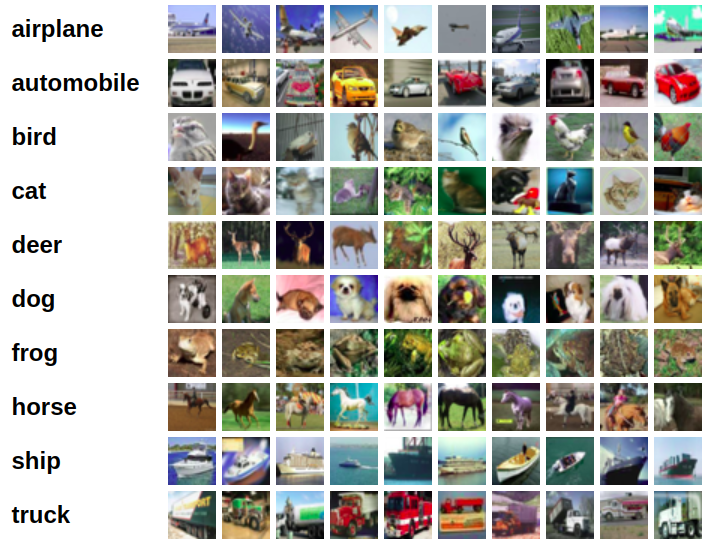

### 0. Import libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

### 1. Load the Dataset
The dataset is already a part of the Keras library, so we can quickly load it using the following command

In [2]:
# Load CIFAR10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()  # Fixed dataset name

# Define class labels (corrected index-to-label mapping)
labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


The following numbered labels represent the labels in the dataset:

In [3]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

### 2. Data Examination

Fistly, lets have a look and the couple of images we have,

In [8]:
def display_random_images(x_data: np.array, y_data: np.array, count: int = 10) -> None:
    # Generate random indices
    indices = np.arange(len(x_data))  # Fixed: Generate array of indices
    selected_ind = np.random.choice(indices, count)

    # Select images and labels
    selected_img = x_data[selected_ind]
    selected_labels_encoded = y_data[selected_ind]
    selected_labels = [labels[x[0]] for x in selected_labels_encoded]  # Fixed: x[0] instead of x[e]

    # Concatenate images horizontally
    concat_img = np.concatenate(selected_img, axis=1)

    # Plot images
    plt.figure(figsize=(20, 10))
    plt.imshow(concat_img)

    # Add labels
    for id_label, label in enumerate(selected_labels):
        plt.text((32/2) + 32 * id_label - len(label), 32 * (5/4), label, color='white', backgroundcolor='black')

    plt.axis('off')  # Fixed: Added missing dot
    plt.show()


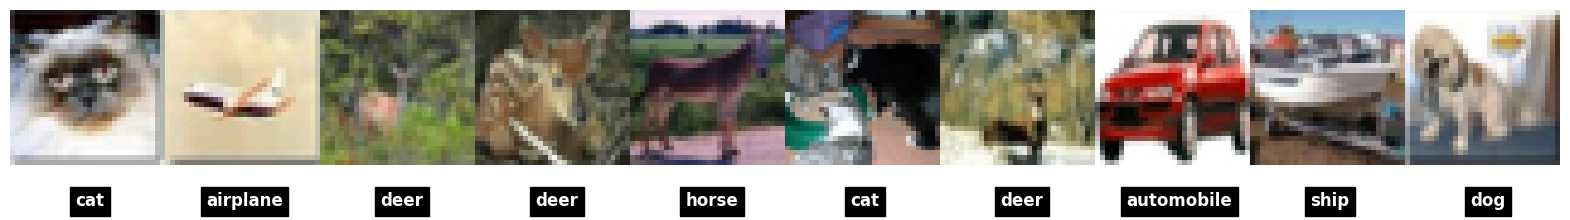

In [9]:
display_random_images(X_train, y_train)


In [11]:
# Check dataset dimensions
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In our dataset, we have 60000 images with 32x32 resolution. Each image has three channels (R, G, B). We have 50000 images for training and 10000 images for testing. Each channel for each image has values from 0 - 255, where each number represents the pixel intensity.
With the combination of intensities of R, G and B, you can display up to 16,777,216 different colours (256^3)

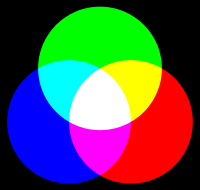

Here you can display each channel separately:

In [12]:
def display_channels_separately(image: np.array) -> None:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

    # Red channel
    axs[0].imshow(image[:,:,0], cmap='Reds')
    axs[0].set_title('Red Channel')

    # Green channel
    axs[1].imshow(image[:,:,1], cmap='Greens')
    axs[1].set_title('Green Channel')

    # Blue channel
    axs[2].imshow(image[:,:,2], cmap='Blues')
    axs[2].set_title('Blue Channel')

    # Original image
    axs[3].imshow(image)
    axs[3].set_title('Original Image')

    # Remove axis ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

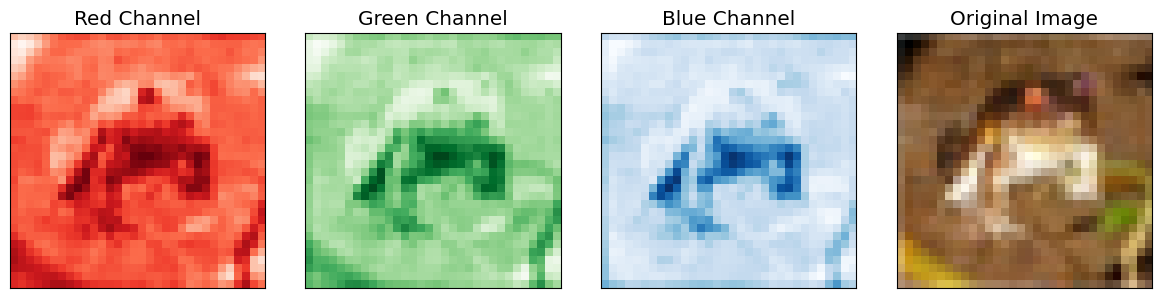

In [13]:
display_channels_separately(X_train[0])

### 3. Preprocessing of the images

For machine learning purposes, we have to preprocess our images. Firstly we need to scale our images, to scale intensity values from 0-1 (min-max scaling)

In [15]:
# Scale pixel values to [0, 1] (use uppercase X_train)
X_train_scaled = X_train.astype('float32') / 255.0
X_test_scaled = X_test.astype('float32') / 255.0  # Optional: Apply to test data


We need to one-hot-encode the labels in our ground truth variable as our second preprocessing.

In [16]:

# One-hot encode labels (ensure y_train is lowercase)
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)  # Optional: Encode test labels

### 4. Define the model architecture

In [18]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))  # Fix: Use parentheses and correct syntax
model.add(Dense(128, activation='relu'))     # Recommended: Replace sigmoid with ReLU
model.add(Dense(10, activation='softmax'))

We will define *the Sequential* model as in our last exercise. This time we will use a different approach to determine the input layers. Instead of specifying the *input_dim* parameter in our first hidden layer, we will create a **Flatten** layer that takes our 32x32x3 image and reshapes it into 1x3072.

We will specify ten neurons in our output layer because we have 10 possible outputs and a **softmax** activation function that returns us a probability distribution over the classes. The class with the highest probability is typically chosen as the predicted class for a given input.

Check the description of our model:

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

The next step is to compile our model, we will use *categorical_crossentropy* as a loss function, *stochastic gradient descend* as an optimisation and we will be checking *the accuracy* metric.

In [20]:
optimizer = SGD(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### 5. Train the model

Our model will be trained in the same way as in our last pc_labs,

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1778 - loss: 2.2389 - val_accuracy: 0.2578 - val_loss: 2.0937
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2706 - loss: 2.0753 - val_accuracy: 0.2939 - val_loss: 2.0189
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2965 - loss: 2.0060 - val_accuracy: 0.3093 - val_loss: 1.9730
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3133 - loss: 1.9625 - val_accuracy: 0.3262 - val_loss: 1.9394
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3289 - loss: 1.9324 - val_accuracy: 0.3349 - val_loss: 1.9136
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3406 - loss: 1.9074 - val_accuracy: 0.3427 - val_loss: 1.8926
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3415 - loss: 1.8867 - val_accuracy: 0.3509 - val_loss: 1.8777
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3499 - loss: 1.8759 - val_accura

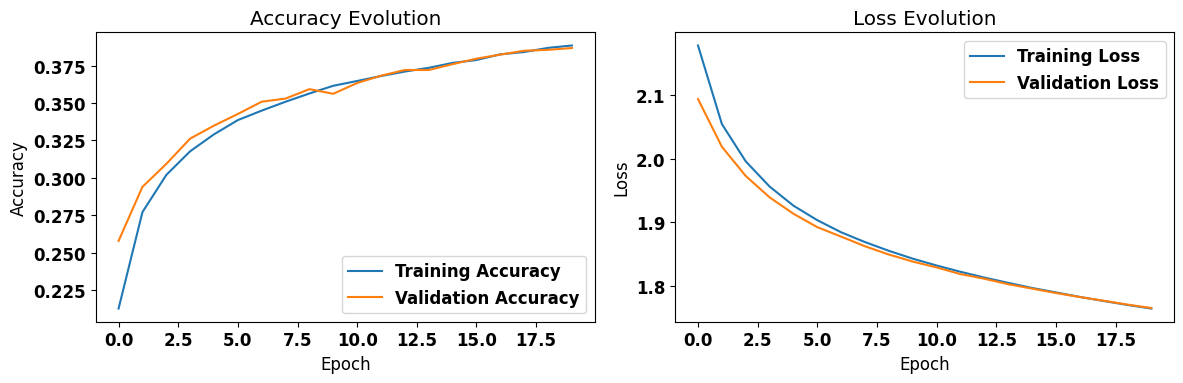

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3887 - loss: 1.7672

Test accuracy: 0.3868


In [21]:
# Fix: Use y_train_encoded instead of X_train_encoded
history = model.fit(
    X_train_scaled,
    y_train_encoded,  # Corrected labels
    epochs=20,
    batch_size=128,
    validation_data=(X_test_scaled, y_test_encoded)  # Use test data for validation
)
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded)
print(f"\nTest accuracy: {test_acc:.4f}")
from keras.layers import Dropout
from keras.regularizers import l2

# Improved architecture
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# Use Adam optimizer
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 6. Model evaluation

In [22]:
X_test = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=10)

In [23]:
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 3.0511257648468018
Test accuracy: 9.89999994635582 %


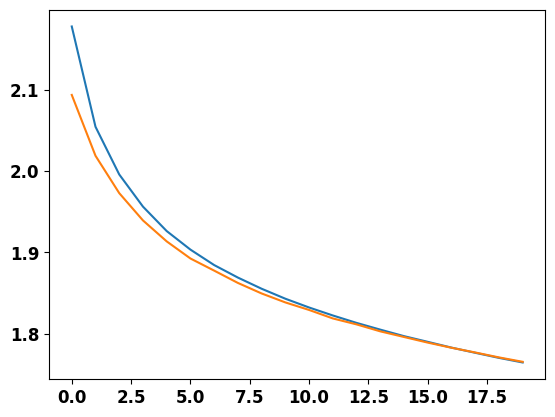

In [24]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

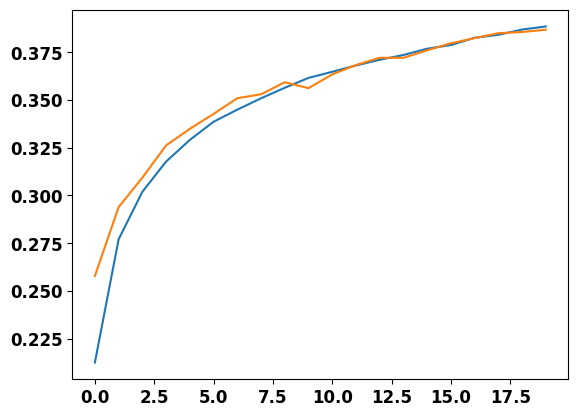

In [25]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

As you can see from the evaluation above, we was able to achive approx. 30% of an accuracy. In other word approx. 70% of an images we classified wrongly. That is really bad!

Lets check the best predictions from our model:

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


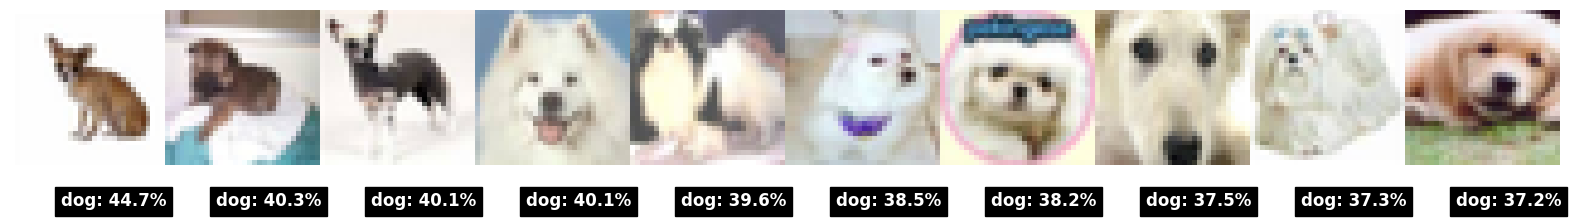

In [26]:
def show_the_best_predictions(model, x_test: np.array, y_test: np.array, n_of_pred: int = 10) -> None:
    # Define correct label mapping
    mapping = {
        0: "airplane", 1: "automobile", 2: "bird", 3: "cat",
        4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
    }

    # Preprocess data and make predictions
    predictions = model.predict(x_test)
    y_test = y_test.reshape(-1)

    # Get predicted classes and confidence scores
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)

    # Find correct predictions
    correct_mask = (predicted_classes == y_test)
    correct_indices = np.where(correct_mask)[0]

    # Sort by confidence score
    sorted_indices = np.argsort(confidence_scores[correct_indices])[::-1]  # Descending order
    top_indices = sorted_indices[:n_of_pred]

    # Prepare visualization
    plt.figure(figsize=(20, 3))
    images = x_test[correct_indices][top_indices]
    labels = y_test[correct_indices][top_indices]
    confidences = confidence_scores[correct_indices][top_indices]

    # Concatenate images horizontally
    concat_img = np.concatenate(images, axis=1)

    # Display image with labels
    plt.imshow(concat_img)
    plt.axis("off")

    # Add labels
    for i in range(n_of_pred):
        label_text = f"{mapping[labels[i]]}: {confidences[i]*100:.1f}%"
        plt.text(32*i + 10, 40, label_text,
                color='white', backgroundcolor='black',
                fontsize=12, weight='bold')

    plt.show()

# Usage
show_the_best_predictions(model, X_test_scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


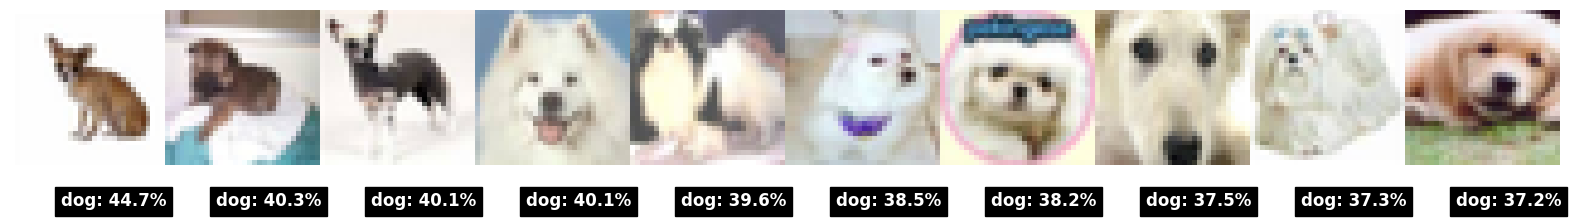

In [27]:
show_the_best_predictions(model, X_test, y_test)

### Task Description:

You task of this exercise would be to improve the model's performance to achieve better results in image classification task. There is no need to change the preprocessing of the dataset. There are possible way how to improve the models performance:

1. Hyperparameter tunning - change the hyperparameters so that the model will perform better. You can experiment with the following:
 - *changing the number of neurons in the hidden layer*
 - *changing the number of hidden layers*
 - *changing the activation functions*
 - *changing the learning rate*
 - *changing the optimizer* - So far, we have used only Gradient descend as our optimizer, but Keras offers other algorithms that can perform better - check the documentation!
 - *changing the number of learning epochs*\
 - *changing the batch size*

2. Regularization techniques - There are several regularization techniques that can improve the model's performance:
 - *Dropout* -  In the Keras lib. you can add *dropout layer* into your Sequential model using the following command  *model.add(Dropout(p))* where *p* is an hyperparameter that controls dropout probabily, typical values are 0.1 - 0.5.
 - *L1, L2 regularization* - In keras the regularization is applied for selected layers, there is an example how to add l2 regularization to an layer (for more details check the documnetation):  *model.add(Dense(64, activation='relu', input_dim=100, kernel_regularizer=l2(0.01)))*
 - *Early stopping* -  In Keras, you can use the EarlyStopping callback to implement early stopping in your model. *early_stopping = EarlyStopping(monitor='val_loss', patience=3)*,  *model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])*


Try to make the highest testing accuracy possible. You can directly edit the code that is presented above, or you can copy everything into new cells. Please submit only the code with the best performance and briefly describe what approaches you have tried and what were the results

### WRITE YOUR DESCRIPTION IN THIS CELL ###

### Voluntary task:
Implement one of the hyperparameter tunning algorithms discussed in the lecture, such as *Grid Search*, *Random Search* or more sophisticated ones. Some of these algorithms are already included in the Keras. Check the documentation